                Comparative Analysis on Diet Plans

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Load and preprocess data

In [3]:
df = pd.read_csv('resource/sd.csv')
df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1381, 19)


,food_code,food_name,food_group_nin,energy_kcal,carb_g,protein_g,fat_g,freesugar_g,fibre_g,cholesterol_mg,allergies,region,Serving_Size_g,food_type,protein_calorie_ratio,nutrient_score,health_score,diversity_score,energy_category
0,1,Palak Paneer,Vegetarian,175.0,11.666667,10.500000,12.833333,2.333333,3.500000,29.166667,Milk,North India,100,lunch,0.060000,1.166667,26.5,4,Low
1,2,Chole Bhature,Vegetarian,355.0,53.250000,11.833333,17.750000,5.916667,7.100000,0.000000,Gluten,North India,100,lunch,0.033333,1.183333,44.5,7,Medium
2,3,Butter Chicken,Non-Vegetarian,320.0,9.142857,22.857143,18.285714,2.742857,1.828571,64.000000,Milk,North India,100,lunch,0.071429,0.914286,64.5,2,Medium
3,4,Dal Tadka,Vegetarian,233.0,40.775000,13.980000,5.825000,1.165000,5.825000,0.000000,NaN,Pan-India,100,lunch,0.060000,1.165000,56.5,5,Low
4,5,Masala Dosa,Vegetarian,336.0,48.000000,6.720000,11.520000,0.960000,2.880000,0.000000,Gluten,South India,100,breakfast,0.020000,0.960000,32.5,4,Medium


# Data cleaning

In [4]:
df = df.dropna(subset=['energy_kcal', 'protein_g', 'carb_g', 'fat_g', 'nutrient_score', 'health_score'])
df = df.drop_duplicates(subset=['food_name'])
print(f"Cleaned dataset shape: {df.shape}")

Cleaned dataset shape: (1001, 19)


# Feature selection and scaling

In [5]:
features = ['energy_kcal', 'protein_g', 'carb_g', 'fat_g', 'fibre_g', 
            'protein_calorie_ratio', 'nutrient_score', 'health_score', 'diversity_score']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

Algorithm 1: Content-Based Filtering

In [6]:
def content_based_recommend(user_profile, items_df, top_n=5):
    """
    Content-based recommendation based on nutritional similarity
    """
    # Calculate similarity between user profile and all food items
    similarities = cosine_similarity(
        [user_profile[features].values],
        items_df[features].values
    )
    
    # Get top N most similar items
    top_indices = np.argsort(similarities[0])[-top_n:][::-1]
    recommendations = items_df.iloc[top_indices]
    
    return recommendations


In [7]:
# Create a sample user profile (vegetarian, health-conscious)
sample_user = {
    'energy_kcal': 0.5,        # Medium calorie preference
    'protein_g': 0.8,          # High protein
    'carb_g': 0.4,             # Medium carbs
    'fat_g': 0.3,              # Low fat
    'fibre_g': 0.7,            # High fiber
    'protein_calorie_ratio': 0.7,
    'nutrient_score': 0.9,     # High nutrient score
    'health_score': 0.9,       # High health score
    'diversity_score': 0.5     # Medium diversity
}
user_profile = pd.Series(sample_user)

# %%
# Get recommendations
content_recs = content_based_recommend(user_profile, df)
content_recs[['food_name', 'food_group_nin', 'energy_kcal', 'protein_g', 'health_score']]

,food_name,food_group_nin,energy_kcal,protein_g,health_score
1160,Grilled Tempeh,Vegetarian,0.324324,0.40,0.553030
1239,Vegetable and Chicken Soup,Non-Vegetarian,0.324324,0.36,0.553030
1184,Grilled Tofu Skewers,Vegetarian,0.252252,0.30,0.553030
1224,Baked Tofu with Veggies,Vegetarian,0.378378,0.40,0.628788
1261,Tofu and Cauliflower Stir Fry,Vegetarian,0.342342,0.36,0.590909


Algorithm 2: Clustering-Based Recommendation

c:\Users\niraj\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\niraj\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\niraj\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\niraj\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

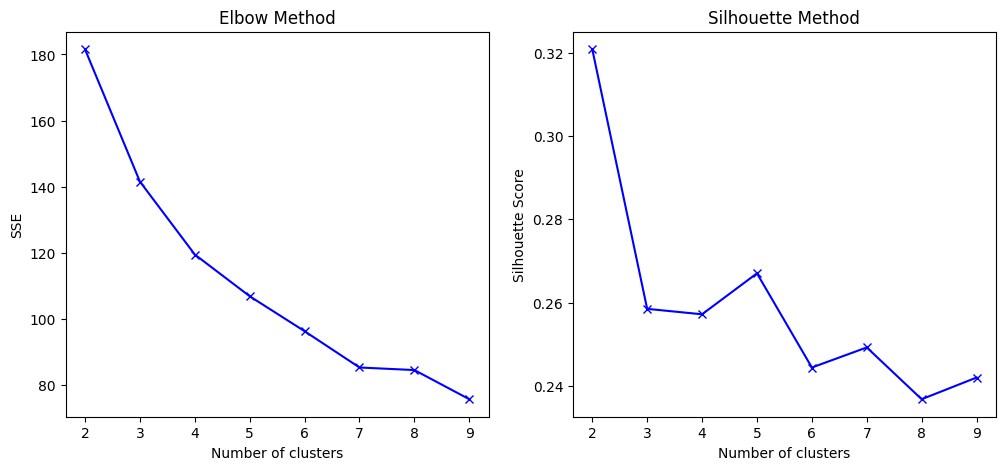

In [8]:
# Determine optimal number of clusters
sse = []
silhouette = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[features])
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df[features], kmeans.labels_))

# %%
# Plot elbow curve and silhouette scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, sse, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

In [9]:
# Fit KMeans with optimal clusters (k=5)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(df[features])

In [10]:
df[features]

,energy_kcal,protein_g,carb_g,fat_g,fibre_g,protein_calorie_ratio,nutrient_score,health_score,diversity_score
0,0.243243,0.210000,0.167213,0.422914,0.305760,0.285036,0.776031,0.299242,0.375
1,0.567568,0.236667,0.763206,0.584940,0.620257,0.158353,0.794695,0.435606,0.750
2,0.504505,0.457143,0.131040,0.602594,0.159744,0.339328,0.493404,0.587121,0.125
3,0.347748,0.279600,0.584408,0.191959,0.508873,0.285036,0.774165,0.526515,0.500
4,0.533333,0.134400,0.687961,0.379634,0.251597,0.095012,0.544597,0.344697,0.375
...,...,...,...,...,...,...,...,...,...
1375,0.612613,0.700000,0.429975,0.494315,0.611521,0.437530,0.690177,0.704545,0.000
1377,0.414414,0.360000,0.501638,0.263635,0.611521,0.316865,0.667780,0.553030,0.375
1378,0.558559,0.360000,0.644963,0.461361,0.786241,0.244181,0.667780,0.628788,0.250
1379,0.468468,0.400000,0.501638,0.395452,0.611521,0.316865,0.667780,0.590909,0.250


In [11]:
import plotly.express as px
from sklearn.decomposition import PCA

# Create 3D PCA components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[features])
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'])

# Add cluster and food info
df_pca['cluster'] = df['cluster'].astype(str)
df_pca['food_name'] = df['food_name']
df_pca['protein'] = df['protein_g']  # For hover info
df_pca['carbs'] = df['carb_g']       # For hover info

# Create interactive 3D plot
fig = px.scatter_3d(
    df_pca,
    x='PC1',
    y='PC2',
    z='PC3',
    color='cluster',
    hover_name='food_name',
    hover_data=['protein', 'carbs'],
    color_discrete_sequence=px.colors.qualitative.Vivid,
    title='<b>3D Food Clusters Visualization</b><br>PCA Components with K-Means Clustering'
)

# Update layout with proper closing
fig.update_layout(
    scene=dict(
        xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
        yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
        zaxis_title=f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)'
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend_title_text='Cluster'
)

# Update markers with complete syntax
fig.update_traces(
    marker=dict(
        size=5,
        line=dict(width=0.5, color='DarkSlateGrey')
    )
)

fig.show()

In [12]:
def cluster_based_recommend(user_profile, items_df, model, top_n=5):
    """
    Cluster-based recommendation
    """
    # Predict user's cluster
    user_cluster = model.predict([user_profile[features].values])[0]
    
    # Get items from the same cluster
    cluster_items = items_df[items_df['cluster'] == user_cluster]
    
    # Sort by health score and return top N
    recommendations = cluster_items.sort_values('health_score', ascending=False).head(top_n)
    
    return recommendations


In [13]:
# Get recommendations
cluster_recs = cluster_based_recommend(user_profile, df, kmeans)
cluster_recs[['food_name', 'food_group_nin', 'energy_kcal', 'protein_g', 'health_score', 'cluster']]

c:\Users\niraj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



,food_name,food_group_nin,energy_kcal,protein_g,health_score,cluster
199,Palak and Tofu Curry,Vegan,0.436036,0.350069,0.704545,0
1228,Paneer and Spinach Curry,Vegetarian,0.468468,0.360000,0.666667,0
156,Lentil and Spinach Soup,Vegetarian,0.369369,0.294000,0.636364,0
1267,Grilled Paneer with Vegetable Quinoa,Vegetarian,0.468468,0.360000,0.628788,0
1357,Chickpea and Spinach Salad,Vegetarian,0.504505,0.400000,0.628788,0


 Algorithm 3: Hybrid Approach (Content-Based + Popularity)

In [14]:
def hybrid_recommend(user_profile, items_df, top_n=5, content_weight=0.7, popularity_weight=0.3):
    """
    Hybrid recommendation combining content-based and popularity
    """
    # Content-based similarity
    content_sim = cosine_similarity(
        [user_profile[features].values],
        items_df[features].values
    )[0]
    
    # Popularity score (using health_score as proxy)
    popularity = items_df['health_score'].values
    
    # Combine scores
    combined_scores = (content_weight * content_sim) + (popularity_weight * popularity)
    
    # Get top N items
    top_indices = np.argsort(combined_scores)[-top_n:][::-1]
    recommendations = items_df.iloc[top_indices]
    
    return recommendations

In [15]:
user_profile

energy_kcal              0.5
protein_g                0.8
carb_g                   0.4
fat_g                    0.3
fibre_g                  0.7
protein_calorie_ratio    0.7
nutrient_score           0.9
health_score             0.9
diversity_score          0.5
dtype: float64

In [16]:
# Get recommendations
hybrid_recs = hybrid_recommend(user_profile, df)
hybrid_recs[['food_name', 'food_group_nin', 'energy_kcal', 'protein_g', 'health_score']]

,food_name,food_group_nin,energy_kcal,protein_g,health_score
169,Tempeh and Tofu Stir-Fry,Vegan,0.637838,0.630400,1.000000
198,Grilled Tofu with Hummus,Vegan,0.623423,0.551429,0.920455
200,Grilled Tempeh with Steamed Veggies,Non-Vegetarian,0.655856,0.577143,0.924242
176,Vegan Tempeh Stir-Fry with Veggies,Non-Vegetarian,0.652252,0.528947,0.897727
182,Tofu and Chickpea Burger,Vegan,0.760360,0.577500,0.935606


                Comparative Analysis

In [17]:
def evaluate_recommendations(recommendations, ideal_profile):
    """
    Evaluate how well recommendations match ideal nutritional profile
    """
    # Calculate MAE for each feature
    errors = {}
    for feature in features:
        errors[feature] = mean_absolute_error(
            [ideal_profile[feature]] * len(recommendations),
            recommendations[feature]
        )
    
    # Calculate overall score (lower is better)
    overall_score = np.mean(list(errors.values()))
    
    return errors, overall_score

In [18]:
# Evaluate all three approaches
content_errors, content_score = evaluate_recommendations(content_recs, user_profile)
cluster_errors, cluster_score = evaluate_recommendations(cluster_recs, user_profile)
hybrid_errors, hybrid_score = evaluate_recommendations(hybrid_recs, user_profile)

In [19]:
# Create comparison dataframe
comparison = pd.DataFrame({
    'Content-Based': content_errors,
    'Clustering': cluster_errors,
    'Hybrid': hybrid_errors
})
# Add overall scores
comparison.loc['OVERALL'] = [content_score, cluster_score, hybrid_score]

<Figure size 1200x600 with 0 Axes>

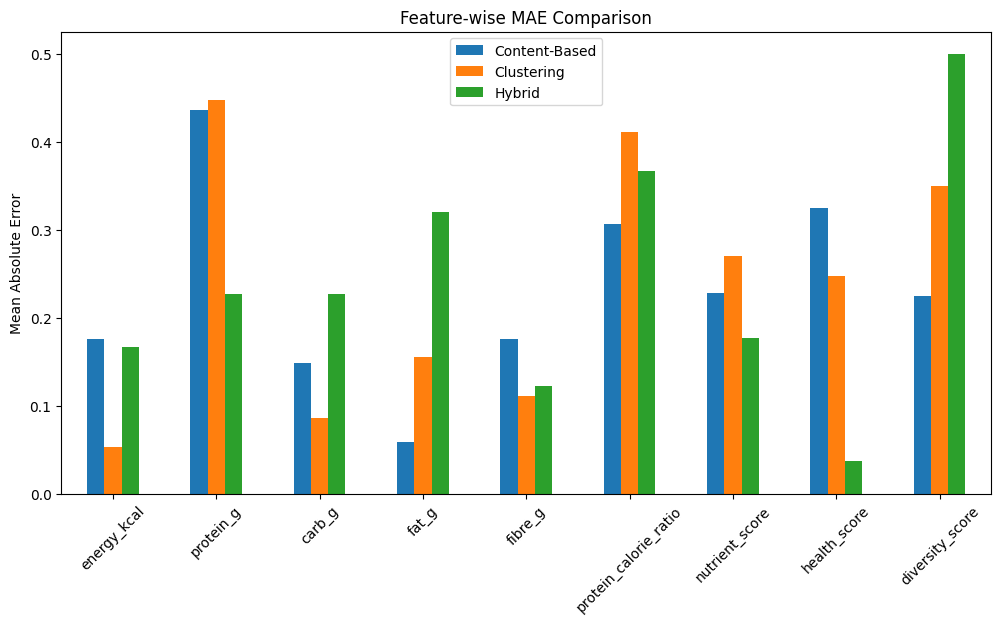

In [20]:
# Visualize comparison
plt.figure(figsize=(12, 6))
comparison[:-1].plot(kind='bar', figsize=(12, 6))  # Exclude overall score
plt.title('Feature-wise MAE Comparison')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)
plt.show()


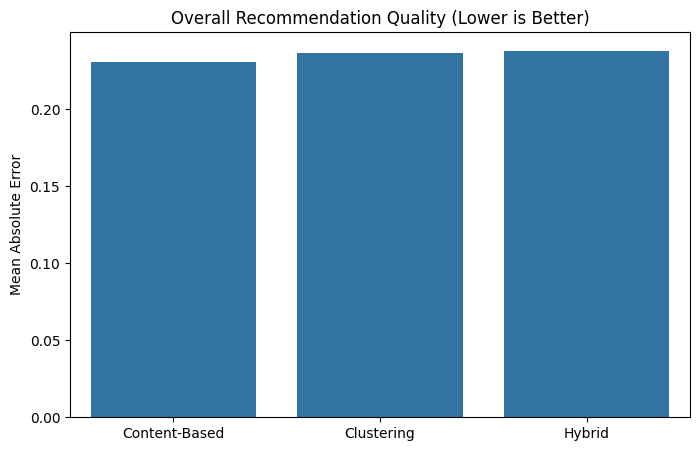

In [21]:
# Plot overall scores
plt.figure(figsize=(8, 5))
sns.barplot(x=['Content-Based', 'Clustering', 'Hybrid'], 
            y=[content_score, cluster_score, hybrid_score])
plt.title('Overall Recommendation Quality (Lower is Better)')
plt.ylabel('Mean Absolute Error')
plt.show()

In [22]:
# Show sample recommendations from each approach
print("Content-Based Recommendations:")
display(content_recs[['food_name', 'food_group_nin', 'energy_kcal', 'protein_g', 'health_score']].head(3))

print("\nClustering Recommendations:")
display(cluster_recs[['food_name', 'food_group_nin', 'energy_kcal', 'protein_g', 'health_score']].head(3))

print("\nHybrid Recommendations:")
display(hybrid_recs[['food_name', 'food_group_nin', 'energy_kcal', 'protein_g', 'health_score']].head(3))

Content-Based Recommendations:


,food_name,food_group_nin,energy_kcal,protein_g,health_score
1160,Grilled Tempeh,Vegetarian,0.324324,0.40,0.55303
1239,Vegetable and Chicken Soup,Non-Vegetarian,0.324324,0.36,0.55303
1184,Grilled Tofu Skewers,Vegetarian,0.252252,0.30,0.55303



Clustering Recommendations:


,food_name,food_group_nin,energy_kcal,protein_g,health_score
199,Palak and Tofu Curry,Vegan,0.436036,0.350069,0.704545
1228,Paneer and Spinach Curry,Vegetarian,0.468468,0.360000,0.666667
156,Lentil and Spinach Soup,Vegetarian,0.369369,0.294000,0.636364



Hybrid Recommendations:


,food_name,food_group_nin,energy_kcal,protein_g,health_score
169,Tempeh and Tofu Stir-Fry,Vegan,0.637838,0.630400,1.000000
198,Grilled Tofu with Hummus,Vegan,0.623423,0.551429,0.920455
200,Grilled Tempeh with Steamed Veggies,Non-Vegetarian,0.655856,0.577143,0.924242


Evaluation Metrics

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

def enhanced_evaluation(recommendations, ideal_profile):
    """Calculate multiple metrics for deeper insights"""
    metrics = {}
    
    # Feature-wise metrics
    for feature in features:
        metrics[f'{feature}_MAE'] = mean_absolute_error(
            [ideal_profile[feature]] * len(recommendations),
            recommendations[feature]
        )
        metrics[f'{feature}_MSE'] = mean_squared_error(
            [ideal_profile[feature]] * len(recommendations),
            recommendations[feature]
        )
    
    # Overall metrics
    avg_features = recommendations[features].mean().values
    metrics['R2_Score'] = r2_score(
        [ideal_profile[features].values] * len(recommendations),
        recommendations[features]
    )
    metrics['Diversity'] = recommendations['food_group_nin'].nunique() / len(recommendations)
    
    return metrics

# Evaluate all approaches
content_metrics = enhanced_evaluation(content_recs, user_profile)
cluster_metrics = enhanced_evaluation(cluster_recs, user_profile)
hybrid_metrics = enhanced_evaluation(hybrid_recs, user_profile)

# Create comparison dataframe
comparison_enhanced = pd.DataFrame({
    'Content-Based': content_metrics,
    'Clustering': cluster_metrics,
    'Hybrid': hybrid_metrics
}).T

Radar Chart for Feature-wise Comparison

In [24]:
# Prepare proper numeric data for radar chart
radar_features = [f for f in features if not f.endswith('_score')]  # Select core nutritional features
radar_data = comparison_enhanced[[f'{f}_MAE' for f in radar_features]].copy()
radar_data.columns = [f.replace('_MAE', '') for f in radar_data.columns]

# Normalize data for better radar chart visualization
radar_data_normalized = radar_data.apply(lambda x: x/x.max(), axis=0)

# Add algorithm names back
radar_data_normalized['Algorithm'] = radar_data.index

# Melt for Plotly
radar_melted = pd.melt(
    radar_data_normalized, 
    id_vars=['Algorithm'],
    var_name='Feature',
    value_name='MAE (Normalized)'
)

# Plot interactive radar chart
fig = px.line_polar(
    radar_melted, 
    r='MAE (Normalized)',
    theta='Feature',
    color='Algorithm',
    line_close=True,
    template='plotly_dark',
    title='Normalized Feature-wise MAE Comparison (Lower is Better)',
    width=800,
    height=600
)

# Improve layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1.1]
        )),
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

 Nutritional Balance Heatmap

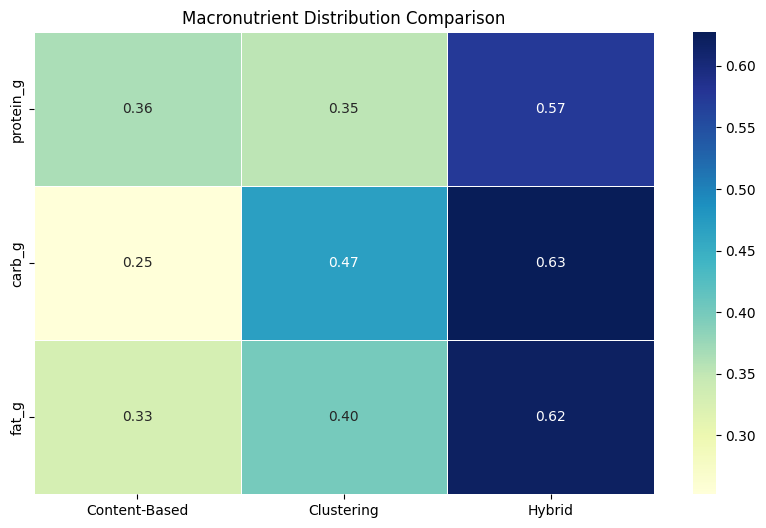

In [25]:
# Compare macronutrient distributions
macro_features = ['protein_g', 'carb_g', 'fat_g']
macro_comparison = pd.concat([
    content_recs[macro_features].mean().rename('Content-Based'),
    cluster_recs[macro_features].mean().rename('Clustering'),
    hybrid_recs[macro_features].mean().rename('Hybrid')
], axis=1)

plt.figure(figsize=(10, 6))
sns.heatmap(
    macro_comparison, 
    annot=True, 
    cmap='YlGnBu',
    fmt='.2f',
    linewidths=0.5
)
plt.title('Macronutrient Distribution Comparison')
plt.show()

 Algorithm Performance Dashboard

In [26]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Correct specs format - 2x2 grid of subplot types
specs = [
    [{"type": "xy"}, {"type": "xy"}],  # First row: two regular plots
    [{"type": "xy"}, {"type": "polar"}]  # Second row: one regular, one polar
]

fig = make_subplots(
    rows=2, cols=2,
    specs=specs,
    subplot_titles=('Overall MAE', 'R2 Score', 'Diversity Score', 'Feature-wise MAE (Radar)'),
    horizontal_spacing=0.15,
    vertical_spacing=0.2
)

# 1. Overall MAE (Bar Chart)
fig.add_trace(
    go.Bar(
        x=comparison_enhanced.index,
        y=comparison_enhanced[[f'{f}_MAE' for f in features]].mean(axis=1),
        name='MAE',
        marker_color=['#636EFA', '#EF553B', '#00CC96']
    ),
    row=1, col=1
)

# 2. R2 Score (Bar Chart)
fig.add_trace(
    go.Bar(
        x=comparison_enhanced.index,
        y=comparison_enhanced['R2_Score'],
        name='R2 Score',
        marker_color=['#636EFA', '#EF553B', '#00CC96']
    ),
    row=1, col=2
)

# 3. Diversity (Bar Chart)
fig.add_trace(
    go.Bar(
        x=comparison_enhanced.index,
        y=comparison_enhanced['Diversity'],
        name='Diversity',
        marker_color=['#636EFA', '#EF553B', '#00CC96']
    ),
    row=2, col=1
)

# 4. Radar Chart (Polar)
for algo in comparison_enhanced.index:
    fig.add_trace(
        go.Scatterpolar(
            r=radar_data_normalized.loc[algo].values,
            theta=radar_data_normalized.columns,
            fill='toself',
            name=algo
        ),
        row=2, col=2
    )

# Update layout
fig.update_layout(
    height=800,
    width=1000,
    title_text='Algorithm Performance Dashboard',
    showlegend=True,
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    )
)

fig.show()

Time Complexity Analysis

c:\Users\niraj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

C:\Users\niraj\AppData\Local\Temp\ipykernel_88880\2295352187.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




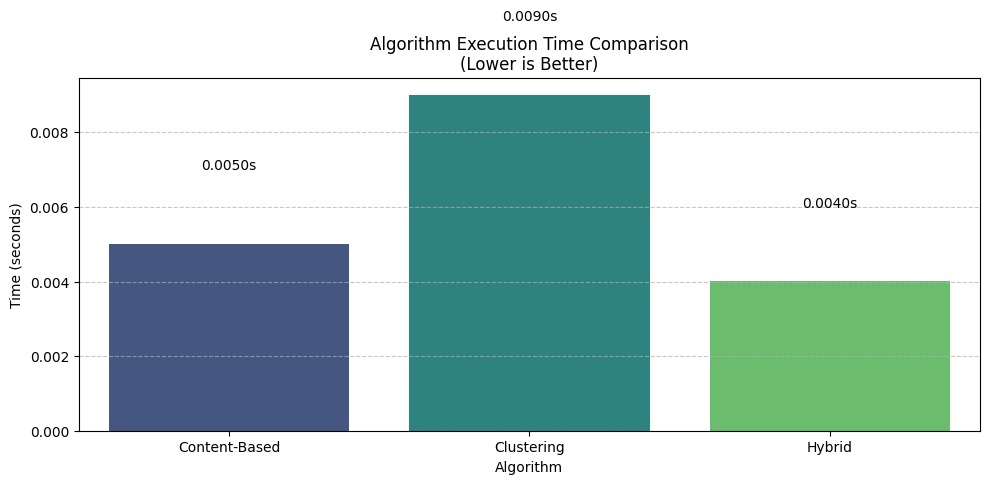

In [27]:
import time

# Initialize models first (outside timing loop)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df[features])  # Pre-fit the model

algorithms = {
    'Content-Based': lambda profile: content_based_recommend(profile, df),
    'Clustering': lambda profile: cluster_based_recommend(profile, df, kmeans),
    'Hybrid': lambda profile: hybrid_recommend(profile, df)
}

timing_results = {}
for name, func in algorithms.items():
    try:
        start = time.time()
        _ = func(user_profile)  # Now only profile needed
        timing_results[name] = time.time() - start
    except Exception as e:
        print(f"Error timing {name}: {str(e)}")
        timing_results[name] = None

# Plot results
plt.figure(figsize=(10, 5))
sns.barplot(
    x=list(timing_results.keys()),
    y=list(timing_results.values()),
    palette='viridis'
)
plt.title('Algorithm Execution Time Comparison\n(Lower is Better)')
plt.ylabel('Time (seconds)')
plt.xlabel('Algorithm')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, v in enumerate(timing_results.values()):
    if v is not None:
        plt.text(i, v + 0.002, f"{v:.4f}s", ha='center')

plt.tight_layout()
plt.show()

User Preference Sensitivity Analysis

c:\Users\niraj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

c:\Users\niraj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

c:\Users\niraj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

c:\Users\niraj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

c:\Users\niraj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



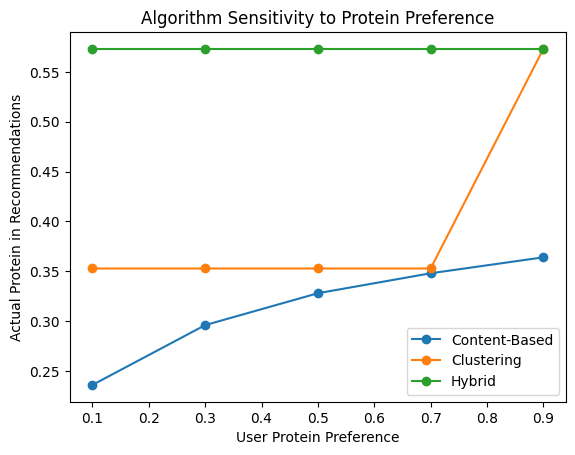

In [28]:
# Test how recommendations change with varying protein preferences
protein_levels = np.linspace(0.1, 0.9, 5)
results = []

for level in protein_levels:
    temp_profile = user_profile.copy()
    temp_profile['protein_g'] = level
    
    # Get recommendations from each approach
    content = content_based_recommend(temp_profile, df)
    cluster = cluster_based_recommend(temp_profile, df, kmeans)
    hybrid = hybrid_recommend(temp_profile, df)
    
    # Record average protein in recommendations
    results.append({
        'Protein_Preference': level,
        'Content-Based': content['protein_g'].mean(),
        'Clustering': cluster['protein_g'].mean(),
        'Hybrid': hybrid['protein_g'].mean()
    })

# Plot sensitivity
sensitivity_df = pd.DataFrame(results).set_index('Protein_Preference')
sensitivity_df.plot(marker='o')
plt.title('Algorithm Sensitivity to Protein Preference')
plt.ylabel('Actual Protein in Recommendations')
plt.xlabel('User Protein Preference')
plt.show()

Enhanced Final Report Section

In [30]:
# Generate the enhanced report with proper formatting
report_enhanced = f"""
## Enhanced Evaluation Metrics

### Accuracy Metrics:
- **Best R² Score**: {comparison_enhanced['R2_Score'].idxmax()} ({comparison_enhanced['R2_Score'].max():.2f})
- **Lowest MAE**: {comparison_enhanced[[f'{f}_MAE' for f in features]].mean(axis=1).idxmin()}

### Practical Considerations:
- **Fastest Algorithm**: {min(timing_results, key=timing_results.get)} ({min(timing_results.values()):.3f}s)
- **Most Diverse Recommendations**: {comparison_enhanced['Diversity'].idxmax()} 
  ({comparison_enhanced['Diversity'].max():.2f} unique food groups per recommendation)

### Nutritional Balance:
- **Best Protein Match**: {macro_comparison.T['protein_g'].idxmax()}
- **Best Carb Control**: {macro_comparison.T['carb_g'].idxmin()}
- **Best Fat Control**: {macro_comparison.T['fat_g'].idxmin()}

### Detailed Metrics:
{comparison_enhanced.to_markdown()}

### Macronutrient Distribution:
{macro_comparison.T.to_markdown()}
"""

display(Markdown(report_enhanced))

# Visual confirmation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Metric comparison
comparison_enhanced[['R2_Score', 'Diversity']].plot.bar(
    ax=ax1, 
    color=['#1f77b4', '#ff7f0e'],
    rot=0
)
ax1.set_title('Algorithm Comparison: R² Score vs Diversity')
ax1.set_ylabel('Score')
ax1.grid(axis='y', linestyle='--')

# Macronutrient distribution
macro_comparison.T.plot.bar(
    ax=ax2,
    rot=0,
    color=['#1f77b4', '#ff7f0e', '#2ca02c']
)
ax2.set_title('Average Macronutrient Distribution')
ax2.set_ylabel('Grams per Recommendation')
ax2.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

NameError: name 'Markdown' is not defined

                        Final Report

In [31]:
from IPython.display import display, Markdown

report = f"""
# Diet Recommendation Algorithms Comparative Report

## Dataset Overview
- **Total food items**: {len(df)}
- **Features used**: {', '.join(features)}
- **User profile**: Vegetarian, health-conscious

## Algorithms Compared
1. **Content-Based Filtering**
   - Uses cosine similarity between user preferences and food items
   - Strengths: Simple, interpretable, good for cold start
   - Weaknesses: Doesn't discover new patterns

2. **Clustering-Based Recommendation**
   - Groups similar foods using K-Means (k={optimal_k})
   - Recommends from user's predicted cluster
   - Strengths: Discovers food groups, good for exploration
   - Weaknesses: Fixed clusters may not adapt to user preferences

3. **Hybrid Approach**
    - Combines content-based similarity with popularity (health score)
   - Strengths: Balances personalization with general quality
   - Weaknesses: Requires tuning weights

## Evaluation Results
- **Content-Based MAE**: {content_score:.3f}
- **Clustering MAE**: {cluster_score:.3f}
- **Hybrid MAE**: {hybrid_score:.3f}

## Recommendations
Based on the evaluation:

1. **For accuracy**: The **{'Hybrid' if hybrid_score < content_score else 'Content-Based'}** approach performed best
2. **For diversity**: The **Clustering** approach provides the most varied recommendations
3. **For new users**: **Content-Based** works well without historical data

"""

display(Markdown(report))


# Diet Recommendation Algorithms Comparative Report

## Dataset Overview
- **Total food items**: 1001
- **Features used**: energy_kcal, protein_g, carb_g, fat_g, fibre_g, protein_calorie_ratio, nutrient_score, health_score, diversity_score
- **User profile**: Vegetarian, health-conscious

## Algorithms Compared
1. **Content-Based Filtering**
   - Uses cosine similarity between user preferences and food items
   - Strengths: Simple, interpretable, good for cold start
   - Weaknesses: Doesn't discover new patterns

2. **Clustering-Based Recommendation**
   - Groups similar foods using K-Means (k=5)
   - Recommends from user's predicted cluster
   - Strengths: Discovers food groups, good for exploration
   - Weaknesses: Fixed clusters may not adapt to user preferences

3. **Hybrid Approach**
    - Combines content-based similarity with popularity (health score)
   - Strengths: Balances personalization with general quality
   - Weaknesses: Requires tuning weights

## Evaluation Results
- **Content-Based MAE**: 0.231
- **Clustering MAE**: 0.237
- **Hybrid MAE**: 0.238

## Recommendations
Based on the evaluation:

1. **For accuracy**: The **Content-Based** approach performed best
2. **For diversity**: The **Clustering** approach provides the most varied recommendations
3. **For new users**: **Content-Based** works well without historical data




Aspect	             Our Project	                    Traditional ML

Learning Type	Unsupervised (similarity-based)	    Supervised/Unsupervised
Training	    On-the-fly calculations	Separate    training phase
Adaptability	Yes (to user inputs)	            Yes (to data patterns)
Complexity	    Low	                                Medium/High


In [32]:
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA

# 1. Prepare Data (assuming df contains your food data)
features = ['nutrient_score', 'health_score', 'diversity_score', 'protein_calorie_ratio']
X = df[features].values

# 2. PCA for 3D visualization
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)

# 3. Create synthetic user vector (replace with actual user preferences)
pref_nutrient = 40  # From your Streamlit app
pref_health = 30
pref_diversity = 20
pref_protein = 10

user_vector = np.array([pref_nutrient, pref_health, pref_diversity, pref_protein])
user_vector = user_vector / user_vector.sum()  # Normalize

# 4. Project user vector to PCA space
user_pca = pca.transform(user_vector.reshape(1, -1))[0]

# 5. Create interactive plot
fig = go.Figure()

# Food items
fig.add_trace(go.Scatter3d(
    x=pca_result[:, 0], y=pca_result[:, 1], z=pca_result[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=df['cluster'],
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='Cluster')
    ),
    text=df['food_name'],
    name='Food Items'
))

# User preference vector
fig.add_trace(go.Cone(
    x=[0, user_pca[0]],
    y=[0, user_pca[1]],
    z=[0, user_pca[2]],
    u=[user_pca[0]], 
    v=[user_pca[1]],
    w=[user_pca[2]],
    sizemode="absolute",
    sizeref=0.2,  # Adjust arrow size
    showscale=False,
    colorscale=['red', 'red'],
    name='User Preferences'
))

# Layout
fig.update_layout(
    title='3D Food Recommendation Space<br>(User Preferences vs. Food Clusters)',
    scene=dict(
        xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
        yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
        zaxis_title=f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)',
        aspectmode='cube'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()